### Statistical API Tutorial

# Generating Time Series from Agricultural Indices with PlanetScope

## Overview

In this tutorial, you will learn how to:

1. Create and post Statistical API requests to calculate agricultural indices
2. Use Statistical API responses with Python libraries like `pandas`, `Matplotlib`, `tslearn`, and `ipyleaflet`
3. Process and analyze time series data further in Python by doing additional data cleanup, clustering, and calculating area under the curve

#### Requirements

This tutorial uses data from [Planet Sandbox Data](https://collections.sentinel-hub.com/planet-sandbox-data/).  In order to access this data, you need a paid Sentinel Hub or Planet license.

You will also need to have a Sentinel Hub account, which you can access from your [Planet Account page](https://account.planet.com/) or [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/#/). Following this tutorial will consume processing units.

##### Import Packages

In [12]:
from ipyleaflet import Map, GeoData, basemaps
from datetime import timezone, datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
import geopandas as gpd
import pandas as pd
import numpy as np

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
# from tslearn.metrics import cdist_dtw

import warnings
warnings.filterwarnings('ignore')

# Sentinel Hub Python Library
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig
)

##### Authenticate

This tutorial will only be using the Sentinel Hub Python SDK, so you will need to provide credentials for Sentinel Hub.

You can find more information in the documentation on [how to configure the Sentinel Hub Python SDK credentials](https://sentinelhub-py.readthedocs.io/en/latest/configure.html).

In [13]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
else:
    print("Connected to Sentinel Hub")

Connected to Sentinel Hub


##### Provide Areas of Interest

To create our Statistical API requests, we need to specify the areas where we want statistics to be calculated. In this example, we will be using agricultural fields located in Sinaloa, Mexico.

In this area, there is [Sandbox Data available for PlanetScope](https://collections.sentinel-hub.com/planetscope/sandbox-data.html).  You can use this data immediately without ordering for learning how to use the platform.

In [14]:
# Load geojson data into a geopandas dataframe
agriculture_fields = gpd.read_file("agriculture_fields.geojson")

# Get the centroid coordinates to center our map
centroid = agriculture_fields.dissolve().centroid[0]
coordinates = (centroid.y, centroid.x) 

# Create a map and add our field boundaries to the map
m = Map(center=coordinates, zoom = 14, basemap= basemaps.Esri.WorldImagery)

geo_data = GeoData(geo_dataframe = agriculture_fields,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2})

m.add_layer(geo_data)

display(m)

Map(center=[25.83670742193881, -109.30592239281681], controls=(ZoomControl(options=['position', 'zoom_in_text'…

##### Set up Statistical API request parameters

In [23]:
# PlanetScope Sandbox Data Collection
collection_id = "ccb1f8f0-e5bf-4c31-afe5-d8803bcbde2a"
planetscope_data_collection = DataCollection.define_byoc(collection_id)
input_data = SentinelHubStatistical.input_data(planetscope_data_collection)

# Set a time interval
start_time = datetime(2022, 5, 1, tzinfo=timezone.utc)
end_time = datetime(2023, 4, 30, tzinfo=timezone.utc)
time_interval = start_time.strftime('%Y-%m-%d'), end_time.strftime('%Y-%m-%d')

# Specify a resolution - in the units of the provided areas of interest, in this case EPSG:4326
resx = 3.04e-05
resy = 2.7e-05

# Provide an evalscript which determines what statistics should be calculated
# This evalscript calculates several vegetation indices including NDVI, MSAVI, NDRE, and RTVICore
evalscript_path = "evalscripts/vegetation_indices.js"
with open(evalscript_path, 'r') as file:
    evalscript = file.read()

# Feed the data into an aggregation, and specify the aggregation interval as P1D for daily statistics
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript, time_interval=time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

# You can include parameters for historgram calculations, as well.
histogram_calculations = {"clearBand": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}

In [34]:
# For each agriculture field boundary, create a Statistical API request

stats_requests = []

for geo_shape in agriculture_fields.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(agriculture_fields.crs)),
        calculations=histogram_calculations,
        config=config,
    )
    stats_requests.append(request)
    
print("{} Statistical API requests prepared!".format(len(stats_requests)))

38 Statistical API requests prepared!


##### Submit the Statistical API Requests

With the provided example, this should take ~3 minutes.

In [25]:
%%time

download_requests = [stats_request.download_list[0] for stats_request in stats_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

stats_responses = client.download(download_requests)

print("{} Results from the Statistical API!".format(len(stats_responses)))

2 Results from the Statistical API!
CPU times: total: 344 ms
Wall time: 28.3 s


Now we can convert the JSON response from the Statistical API into a `pandas` DataFrame. The table will have the following columns:

| column    | definition |
| -------- | ------- |
| clear mean  | The mean value of the `clear` output, which represents the % of good pixels as determined by the dataMask and UDM clear band  |
| ndre mean | The mean value for the Normalized Difference Red Edge Index |
| ndvi mean    | The mean value for the Normalized Difference Vegetation Index |
| msavi mean | The mean value for the Modified Soil Adjusted Vegetation Index |
| rtvicore mean | The mean value for the Red-Edge Triangulated Vegetation Index |
| date| The date of the observation |
| day_of_year | The day number within a year |
| field_id | The index value from the input geojson field boundaries file |

In [8]:
# Normalize the JSON responses into a list of pandas dataframes
stats_df_list = [pd.json_normalize(per_aoi_stats["data"]) for per_aoi_stats in stats_responses]

# Add the ID from the input geojson file so we know which field goes with which statistics
for df, oid in zip(stats_df_list, agriculture_fields.index):
    df["field_id"] = oid

# Combine all of the dataframes into a single dataframe
stats_df = pd.concat(stats_df_list, ignore_index=True)

# Add date and day_of_year columns
stats_df["date"] = pd.to_datetime(stats_df['interval.from']).dt.date
stats_df["day_of_year"] = stats_df.apply(lambda row: row["date"].timetuple().tm_yday, axis=1)

# Filter and rename the columns to keep only the mean values
mean_columns = [col for col in stats_df.columns if '.mean' in col]
stats_df = stats_df[mean_columns + ["date", "day_of_year", "field_id"]]

# Rename columns to keep only the unique part
renamed_columns = {col: col.split('.')[1] + ' mean' for col in mean_columns}
stats_df = stats_df.rename(columns=renamed_columns)

# Convert mean columns to floats
for col in renamed_columns.values():
    stats_df[col] = pd.to_numeric(stats_df[col], errors='coerce')

# Display the filtered and renamed dataframe
stats_df

,clear mean,ndre mean,ndvi mean,msavi mean,rtvicore mean,date,day_of_year,field_id
0,1.0,0.311484,0.481269,0.643952,128781.563552,2022-05-01,121,0
1,1.0,0.315484,0.487486,0.648951,127397.958409,2022-05-02,122,0
2,1.0,0.309462,0.477871,0.640431,132001.258952,2022-05-03,123,0
3,1.0,0.317833,0.496176,0.656795,117640.435758,2022-05-04,124,0
4,1.0,0.311871,0.472424,0.635459,126389.060316,2022-05-05,125,0
...,...,...,...,...,...,...,...,...
10210,1.0,0.406905,0.528751,0.665817,173085.859903,2023-04-25,115,37
10211,1.0,0.397739,0.509521,0.644887,165506.166667,2023-04-26,116,37
10212,1.0,0.413629,0.529093,0.662465,165269.630435,2023-04-27,117,37
10213,1.0,0.419766,0.517326,0.651812,157955.504831,2023-04-28,118,37


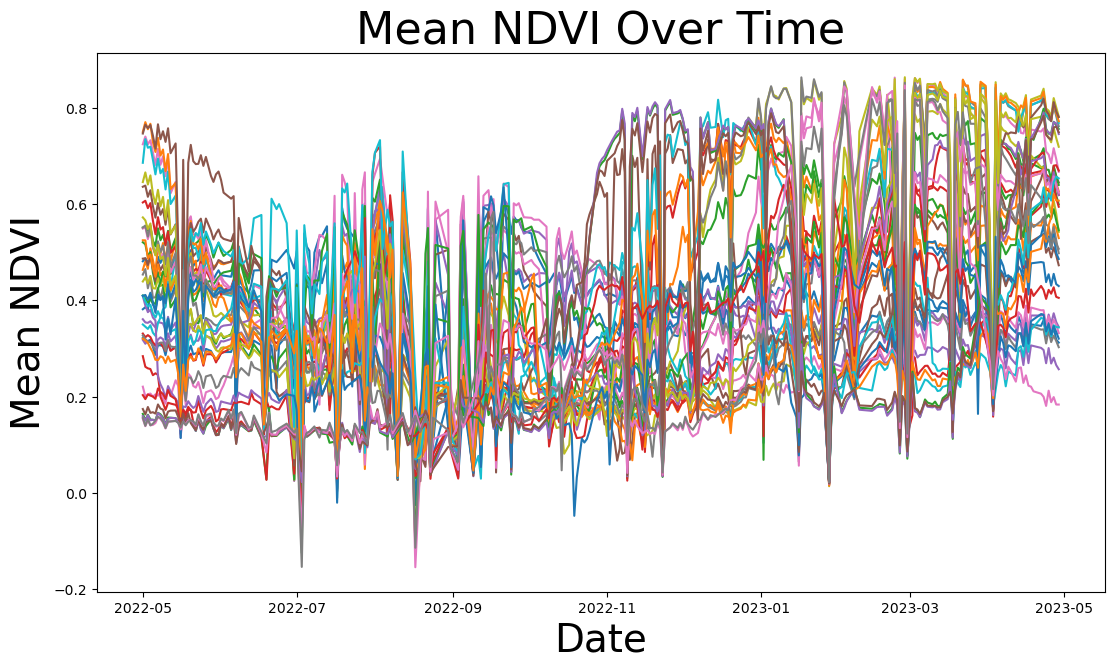

In [9]:
# Ensure numeric types and handle NaN values
stats_df = stats_df.dropna(subset=["ndvi mean"])

fig, ax = plt.subplots(figsize=(13, 7))

for idx, field_id in enumerate(agriculture_fields.index):

    series = stats_df[(stats_df["field_id"] == field_id)]
            
    series.plot(ax=ax, x="date", y="ndvi mean", legend=False)

title = ax.set_title('Mean NDVI Over Time', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

plt.show()

##### Using the `clear mean` column to clean up cloudy statistics

Our chart has a lot of bad observations where there are clouds, let's use the Useable Data Mask to remove these.

In the evalscript (`evalscripts/vegetation_incides.js`), we calculated `clear mean` like so:

    const clear = (sample.dataMask * sample.clear);
    
| band    | 0 | 1 |
| -------- | ------- | ------- |
|`samples.dataMask`| No data | Data |
|`sample.clear` | Usable Data Mask detected not clear pixel | Usable Data Mask detected clear pixel |

Multiplying these two together means that `1` represents valid data which is clear, and `0` represents either no data or cloudy pixels.

Because we used this in a Statistical API response, and the values were either 0 or 1, the `clear mean` effectively represents the percentage of valid pixels within the statistical calculation.

To create useful time series, we want to exclude very cloudy images, and images where we only have data for a fraction of the field.

We can plot this new value `clear mean` to look at how many valid observation we can use.

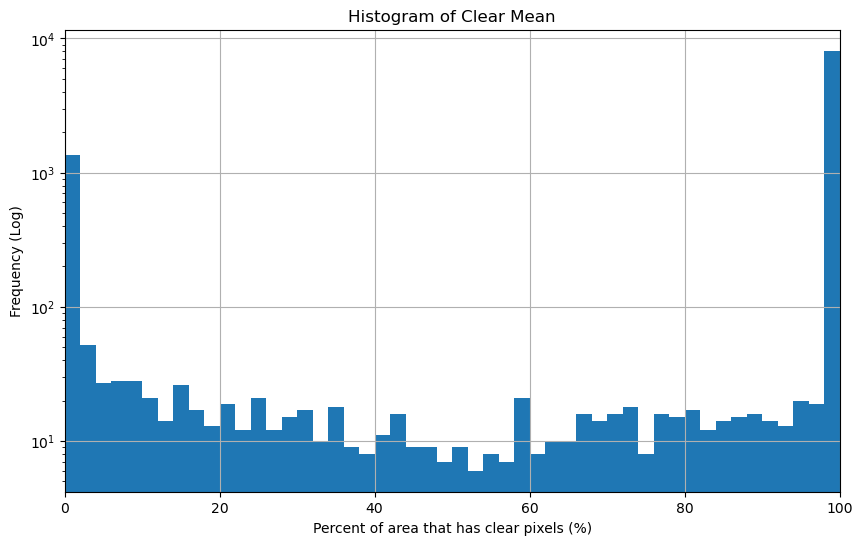

In [10]:
# Convert 'clear mean' to percentage
stats_df['clear percentage'] = stats_df['clear mean'] * 100

# Plot histogram with more bins and logarithmic scale
plt.figure(figsize=(10, 6))
stats_df['clear percentage'].hist(bins=50, log=True)
plt.xlabel('Percent of area that has clear pixels (%)')
plt.ylabel('Frequency (Log)')
plt.xlim(0,100)
plt.title('Histogram of Clear Mean')
plt.show()

We can filter out any statistics where we had less than 95% valid pixels. 

In [11]:
stats_df = stats_df[(stats_df["clear percentage"] > 95)]
stats_df

,clear mean,ndre mean,ndvi mean,msavi mean,rtvicore mean,date,day_of_year,field_id,clear percentage
0,1.0,0.311484,0.481269,0.643952,128781.563552,2022-05-01,121,0,100.0
1,1.0,0.315484,0.487486,0.648951,127397.958409,2022-05-02,122,0,100.0
2,1.0,0.309462,0.477871,0.640431,132001.258952,2022-05-03,123,0,100.0
3,1.0,0.317833,0.496176,0.656795,117640.435758,2022-05-04,124,0,100.0
4,1.0,0.311871,0.472424,0.635459,126389.060316,2022-05-05,125,0,100.0
...,...,...,...,...,...,...,...,...,...
10210,1.0,0.406905,0.528751,0.665817,173085.859903,2023-04-25,115,37,100.0
10211,1.0,0.397739,0.509521,0.644887,165506.166667,2023-04-26,116,37,100.0
10212,1.0,0.413629,0.529093,0.662465,165269.630435,2023-04-27,117,37,100.0
10213,1.0,0.419766,0.517326,0.651812,157955.504831,2023-04-28,118,37,100.0


Now we can plot the time series data to see what it looks like. 

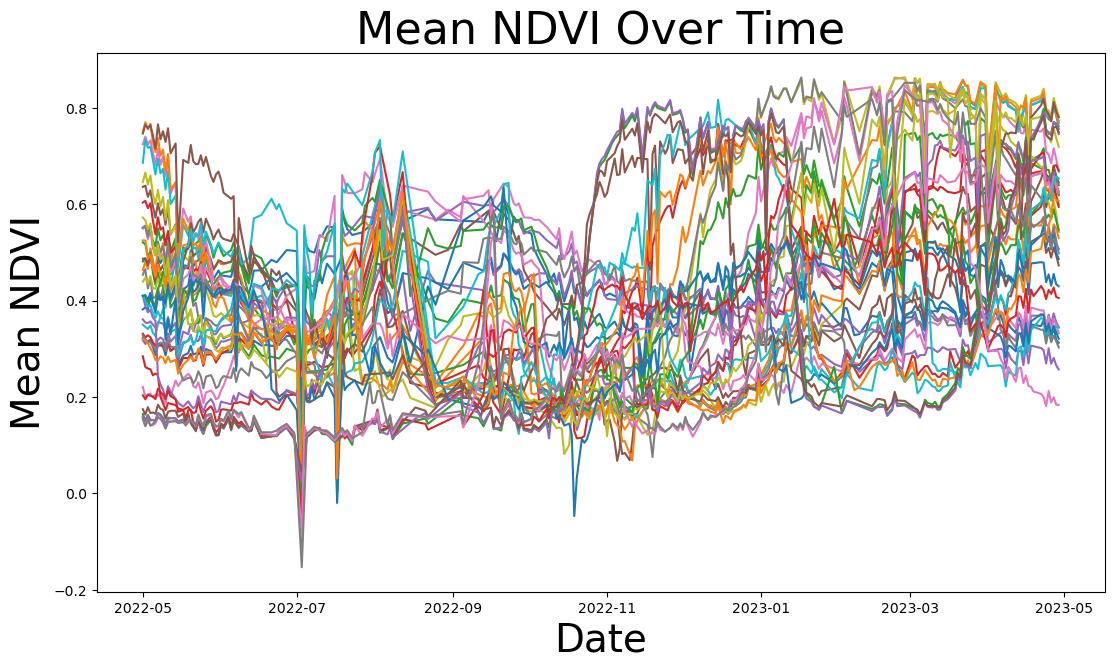

In [12]:
# Ensure numeric types and handle NaN values

fig, ax = plt.subplots(figsize=(13, 7))

for idx, field_id in enumerate(agriculture_fields.index):

    series = stats_df[(stats_df["field_id"] == field_id)]
            
    series.plot(ax=ax, x="date", y="ndvi mean", legend=False)

title = ax.set_title('Mean NDVI Over Time', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

plt.show()

Let's focus in on just one field, and look at the other spectral indices.  Different indices may have more applicability to different regions, crops, or parts of the growing season.

Visualizing the chart for field number 36


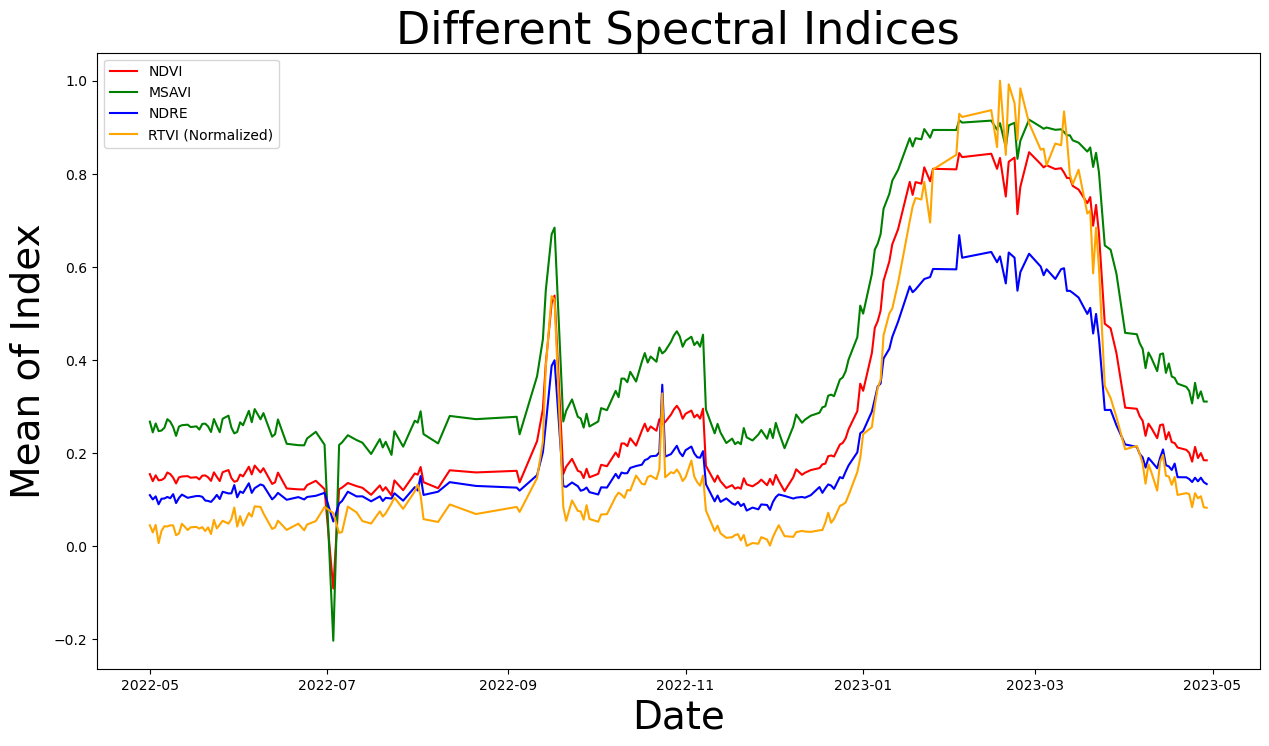

In [13]:
# Select a random field
field_id = np.random.choice(stats_df['field_id'].unique())
print(f"Visualizing the chart for field number {field_id}")

# Filter the data for the selected field where clouds are 0
spectral_df = stats_df[stats_df['field_id'] == field_id]
series = spectral_df[spectral_df["clear mean"] == 1]

# Scale the RTVI mean
series["scaled rtvi mean"] = (series["rtvicore mean"] - series["rtvicore mean"].min()) / (series["rtvicore mean"].max() - series["rtvicore mean"].min())

# Plot the different spectral indices
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(15, 8))

series.plot(ax=ax, x="date", y="ndvi mean", color="red", label="NDVI")
series.plot(ax=ax, x="date", y="msavi mean", color= "green", label="MSAVI")
series.plot(ax=ax, x="date", y="ndre mean", color="blue", label="NDRE")
series.plot(ax=ax, x="date", y="scaled rtvi mean", color="orange", label="RTVI (Normalized)")

ax.set_title('Different Spectral Indices', fontsize=32)
ax.set_ylabel("Mean of Index", fontsize=28)
ax.set_xlabel("Date", fontsize=28)
ax.legend()

plt.show()

There might still be some anomalous data and noise in the time series.  We can make a function to remove statistical outlier and calculate a moving average

In [14]:
# Function to detect and remove outliers and then apply a moving average
def clean_and_smooth(series, outlier_threshold_percentile=95, moving_average_window=3):

    # Remove outliers
    differences = series.diff().abs()
    threshold = np.percentile(differences.dropna(), outlier_threshold_percentile)
    outliers = differences > threshold
    series[outliers] = np.nan
    series = series.ffill().bfill()
    
    # Apply moving average
    smoothed_series = np.convolve(series, np.ones(moving_average_window) / moving_average_window, mode='valid')
    
    # Pad the smoothed series to align with the original series length
    padding = (len(series) - len(smoothed_series)) // 2
    smoothed_series = np.pad(smoothed_series, (padding, len(series) - len(smoothed_series) - padding), mode='edge')#, constant_values=np.nan)
    
    return pd.Series(smoothed_series, index=series.index)

Let's make a function that applies the `clean_and_smooth` function and plots the multiple indices

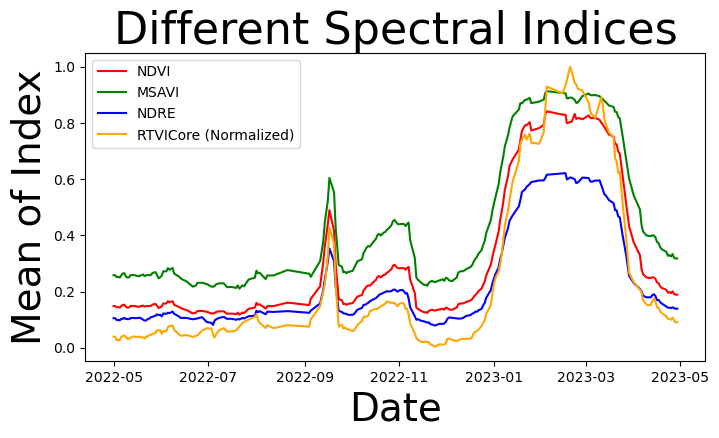

In [16]:
def plot_indices(field_id):
    # Filter the data for the selected field where clouds are 0
    series = stats_df[stats_df['field_id'] == field_id]

    # Apply the combined function to clean and smooth the series
    series['ndvi mean'] = clean_and_smooth(series['ndvi mean'])
    series['msavi mean'] = clean_and_smooth(series['msavi mean'])
    series['ndre mean'] = clean_and_smooth(series['ndre mean'])

    # Scale the RTVI mean to between 0 and 1
    series["scaled_rtvi"] = (series["rtvicore mean"] - series["rtvicore mean"].min()) / (series["rtvicore mean"].max() - series["rtvicore mean"].min())
    series['scaled_rtvi'] = clean_and_smooth(series['scaled_rtvi'])

    # Plot the different spectral indices
    pd.options.mode.chained_assignment = None 

    fig, ax = plt.subplots(figsize=(8, 4))

    series.plot(ax=ax, x="date", y="ndvi mean", color="red", label="NDVI")
    series.plot(ax=ax, x="date", y="msavi mean", color= "green", label="MSAVI")
    series.plot(ax=ax, x="date", y="ndre mean", color="blue", label="NDRE")
    series.plot(ax=ax, x="date", y="scaled_rtvi", color="orange", label="RTVICore (Normalized)")

    ax.set_title('Different Spectral Indices', fontsize=32)
    ax.set_ylabel("Mean of Index", fontsize=28)
    ax.set_xlabel("Date", fontsize=28)
    ax.legend()

    plt.show()

plot_indices(field_id)

Now that we have a function to create the chart, we can call it when a feature is clicked in the `ipyleaflet` map.  We can use this to explore the data for each field.

In [17]:
# Function to handle feature click
def on_feature_click(event, feature, **kwargs):
    field_id = feature["id"]
    output.clear_output()
    with output:
        plot_indices(int(field_id))

m = Map(center=coordinates, zoom = 14, basemap= basemaps.Esri.WorldImagery)

geo_data = GeoData(geo_dataframe = agriculture_fields,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Agriculture Fields')
geo_data.on_click(on_feature_click)

m.add_layer(geo_data)

output = widgets.Output()
with output:
    print("Click on a field to load the chart...")

# Display the map and the output widget
display(widgets.HBox([m, output], layout=widgets.Layout(width='100%', height='100%')))

#### Clustering time series
Each field has a distinct curve, let's use `tslearn` to cluster similar time series.

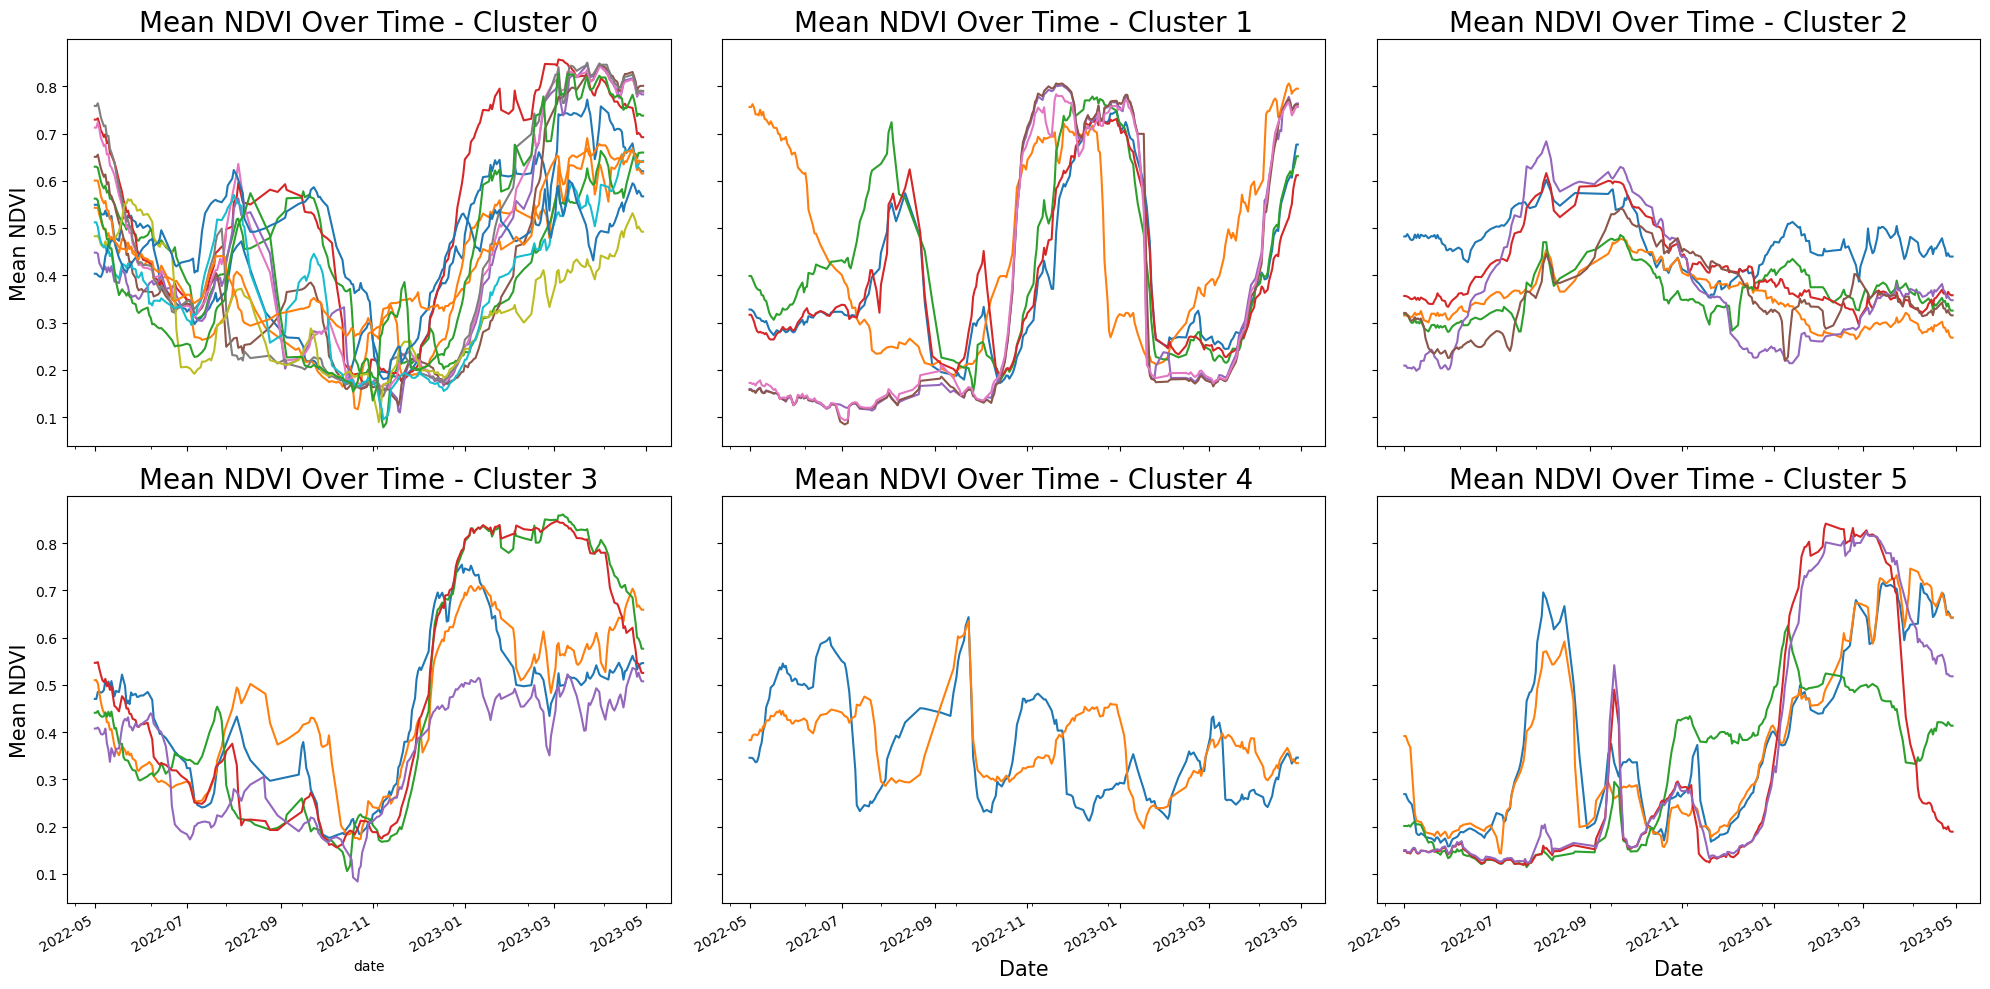

In [18]:
cleaned_smoothed_dfs= []
for field_id in stats_df['field_id'].unique():
    field_df = stats_df[stats_df['field_id'] == field_id].copy()
    field_df = field_df.sort_values(by='date')
    field_df['ndvi mean'] = clean_and_smooth(field_df['ndvi mean'])
    cleaned_smoothed_dfs.append(field_df)
cleaned_smoothed_df = pd.concat(cleaned_smoothed_dfs)

# Preprocess the data to ensure it is in the right format
cleaned_smoothed_df["date"] = pd.to_datetime(cleaned_smoothed_df["date"])
cleaned_smoothed_df = cleaned_smoothed_df.sort_values(by=["field_id", "date"])

# Create a pivot table to have time series data for each field
pivot_df = cleaned_smoothed_df.pivot(index="date", columns="field_id", values="ndvi mean")

# Fill missing values by forward filling and then backward filling
pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')

# Convert the pivot table to a numpy array
time_series_data = pivot_df.T.values

# Normalize the time series data
scaler = TimeSeriesScalerMeanVariance(mu=0.5, std=0.25)
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Apply K-means clustering
n_clusters = 6 # You can change the number of clusters based on your needs
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=100, n_init=5, verbose=False)
labels = kmeans.fit_predict(time_series_data_scaled)

# Add cluster labels to the dataframe
cleaned_smoothed_df['cluster'] = np.nan
agriculture_fields["cluster_id"] = np.nan
for idx, field_id in enumerate(pivot_df.columns):
    cleaned_smoothed_df.loc[cleaned_smoothed_df['field_id'] == field_id, 'cluster'] = labels[idx]
    agriculture_fields.loc[field_id, "cluster_id"] = labels[idx]

# Plot each cluster in its own subplot with 2 columns
n_rows = (n_clusters + 1) // 3  # Calculate the number of rows needed
n_cols = n_clusters / n_rows
fig, axs = plt.subplots(n_rows, 3, figsize=(20, n_rows * 5), sharex=True, sharey=True)

for cluster_id in range(n_clusters):
    ax = axs[cluster_id // 3, cluster_id % 3]
    cluster_data = cleaned_smoothed_df[cleaned_smoothed_df['cluster'] == cluster_id]

    for field_id in cluster_data['field_id'].unique():

        series = cleaned_smoothed_df[(cleaned_smoothed_df["field_id"] == field_id)]
        series.plot(ax=ax, x="date", y="ndvi mean", legend=False)
    
    ax.set_title(f'Mean NDVI Over Time - Cluster {cluster_id}', fontsize=20)
    ax.set_ylabel("Mean NDVI", fontsize=15)
    if cluster_id >= n_clusters - 2:
        ax.set_xlabel("Date", fontsize=15)
    plt.legend = False

plt.tight_layout()
plt.show()

In [22]:
# Get unique clusters for the dropdown
unique_clusters = agriculture_fields['cluster_id'].dropna().unique()
unique_clusters = np.append(unique_clusters, 'All')  # Add an option to show all fields

# Create the dropdown widget
cluster_dropdown = widgets.Dropdown(
    options=unique_clusters,
    value='All',
    description='Cluster:',
)

# Function to handle feature click
def on_feature_click(event, feature, **kwargs):
    field_id = feature["id"]
    output.clear_output()
    with output:
        plot_indices(int(field_id))

# Function to filter the GeoDataFrame based on selected cluster
def filter_agriculture_fields(cluster_id):
    if cluster_id == 'All':
        return agriculture_fields
    else:
        return agriculture_fields[agriculture_fields['cluster_id'] == float(cluster_id)]

# Create the map
m = Map(center=coordinates, zoom=14, basemap=basemaps.Esri.WorldImagery)

# Function to update the map
def update_map(cluster_id):
    filtered_fields = filter_agriculture_fields(cluster_id)
    geo_data = GeoData(
        geo_dataframe=filtered_fields,
        style={'color': 'black', 'fillColor': '#3366cc', 'opacity': 0.05, 'weight': 1.9, 'dashArray': '2', 'fillOpacity': 0.6},
        hover_style={'fillColor': 'red', 'fillOpacity': 0.2},
        name='Agriculture Fields'
    )
    geo_data.on_click(on_feature_click)
    
    # Clear the map layers except for the basemap
    m.layers = [layer for layer in m.layers if (layer.name == "Esri.WorldImagery")]
    m.add_layer(geo_data)

# Initial map update with all fields
update_map('All')

# Display the dropdown and map
def on_dropdown_change(change):
    update_map(change.new)

cluster_dropdown.observe(on_dropdown_change, names='value')

display(widgets.VBox([cluster_dropdown, widgets.HBox([m, output], layout=widgets.Layout(width='100%', height='100%'))]))

##### Area under the curve

We can use `np.trapz` to calculate the area under the time series curve for each field.

In practice you may want to calculate area under the curve within a specific time range, not the entire year.

Field 33 has the LOWEST area under the curve at 111.48.

Field 6 has the HIGHEST area under the curve at 195.64


<Axes: title={'center': 'Distribution of AUC'}, xlabel='Area Under Curve', ylabel='Frequency'>

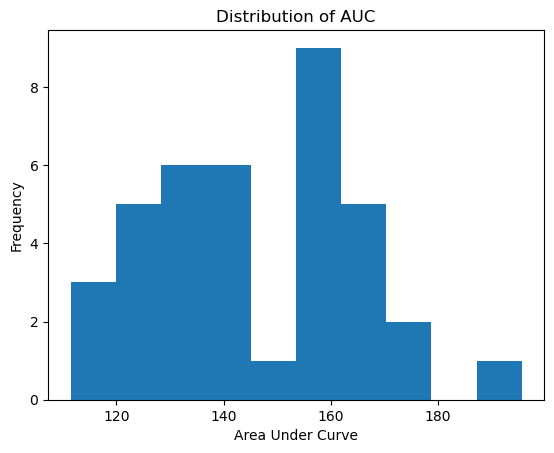

In [23]:
# Initialize an empty list to store the AUC values
aucs = []

# Iterate over each unique field_id
for i in cleaned_smoothed_df['field_id'].unique():
    
    series = cleaned_smoothed_df[(cleaned_smoothed_df["field_id"] == int(i))]
    # Ensure the series is sorted by 'day_of_year'
    series = series.sort_values(by='day_of_year')
    
    # Calculate the area under the curve (AUC) using the trapezoidal rule
    auc = np.trapz(series["ndvi mean"], x=series['day_of_year'])
    
    # Append the field_id and AUC to the list
    aucs.append([str(i), auc])
    
    
# Convert the list to a DataFrame
aucs = pd.DataFrame(aucs, columns=["Field ID", "Area Under Curve"])

# Find the minimum and maximum AUC values
min_auc = aucs.min()
max_auc = aucs.max()

# Find the field_ids with the minimum and maximum AUC
min_max_field_ids = [aucs.loc[aucs["Area Under Curve"].idxmin()]["Field ID"], aucs.loc[aucs["Area Under Curve"].idxmax()]["Field ID"]]

# Print the field_id with the lowest AUC
print("Field {} has the LOWEST area under the curve at {}.".format(aucs.loc[aucs["Area Under Curve"].idxmin()]["Field ID"], aucs.loc[aucs["Area Under Curve"].idxmin()]["Area Under Curve"].round(2)))

# Print the field_id with the highest AUC
print("\nField {} has the HIGHEST area under the curve at {}".format(aucs.loc[aucs["Area Under Curve"].idxmax()]["Field ID"], aucs.loc[aucs["Area Under Curve"].idxmax()]["Area Under Curve"].round(2)))

aucs["Area Under Curve"].plot.hist(xlabel = "Area Under Curve", title = "Distribution of AUC")

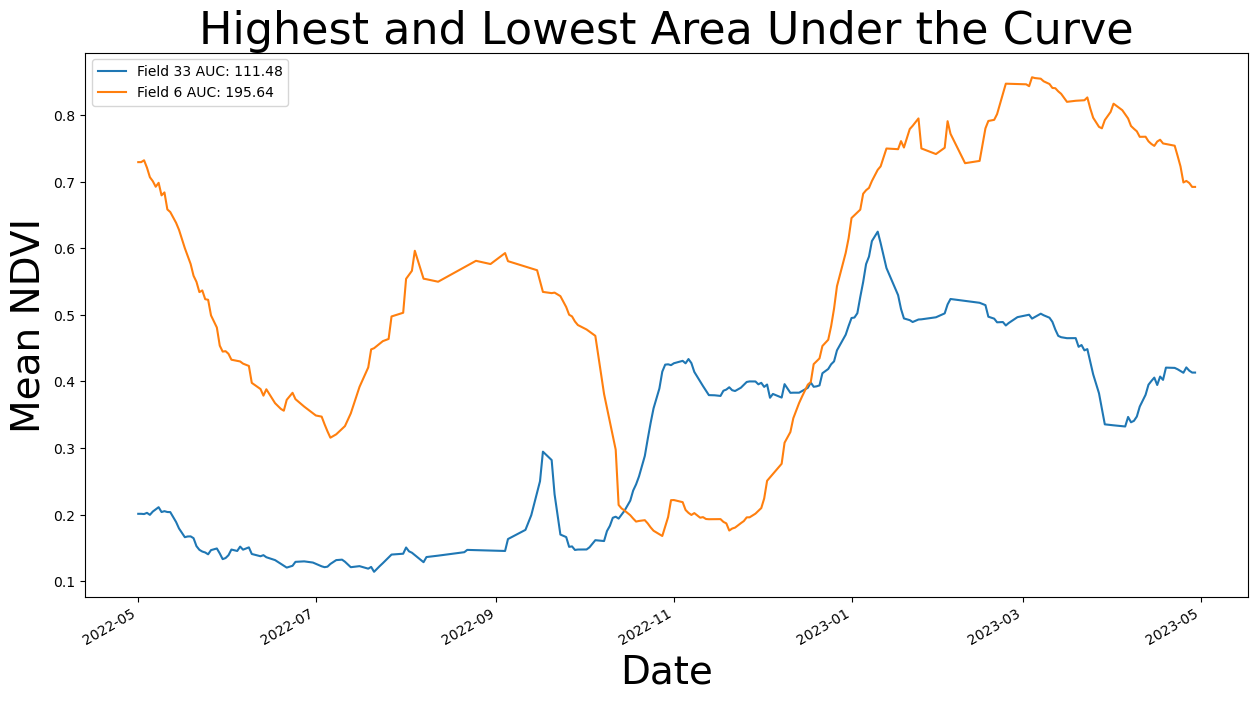

In [24]:
# Plot the highest and lowest AUC

fig, ax = plt.subplots(figsize=(15, 8))


for i in min_max_field_ids:

    series = cleaned_smoothed_df[(cleaned_smoothed_df["field_id"] == int(i))]
    
    # Ensure the series is sorted by 'day_of_year'
    series = series.sort_values(by='day_of_year')
    
    # Calculate AUC using the trapezoidal rule
    auc = np.trapz(series["ndvi mean"], x=series['day_of_year'])
    
    series.plot(ax=ax, x="date", y="ndvi mean", legend=True, label=("Field " + str(i) + " AUC: " + str(round(auc, 2))))

title = ax.set_title('Highest and Lowest Area Under the Curve', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

plt.show()